# ResNet Model Inference — Field Reconstruction Benchmark

This notebook demonstrates **inference** using a pre-trained ResNet model to reconstruct 2D fields from sparse sensor data.

---

**How to use this notebook:**

1. **First**, run the second code cell to define the main inference function (`run_reconstruction_inference`).
2. **Second**, run the first code cell to perform inference.  
   - You may set the `sample_idx` to view reconstructions for different test samples.

**Parameters you can use:**
- `sample_idx`: Change this to see different test samples reconstructed.
- `num_snapshots` and `sen_num`: **Do not change these** unless you have trained your model to exactly match those settings.
    - With the provided pretrained weights and data in this repo, **you should only modify `sample_idx`** for valid inference.

**Important:**  
- If you change `num_snapshots` or `sen_num` to values _other than_ those used during training, the loaded model weights will no longer be valid or give meaningful results.
- By default, this notebook uses:  
  - `num_snapshots=5000`
  - `sen_num=100`  
  which matches the default pretrained ResNet weights in the repo.

---

**Note on CNN Inference:**

- **This notebook is only for ResNet model inference.**
- If you want to use the **Simple CNN** method, you must train it first and then use the relevant inference cells provided in `test.ipynb`.  
- There is no standalone inference script for the CNN; all CNN-related demo, training, and inference code is in `test.ipynb`.

---


--- Starting Inference: Snapshots=5000, Sensors=100, Sample=10 ---


Preprocessing Snapshots: 100%|██████████| 5000/5000 [00:08<00:00, 605.13it/s]


Successfully loaded model weights from ./Model_ResNet_2Dxysec_weights.pth
Generating prediction for sample index 10 from the test set...


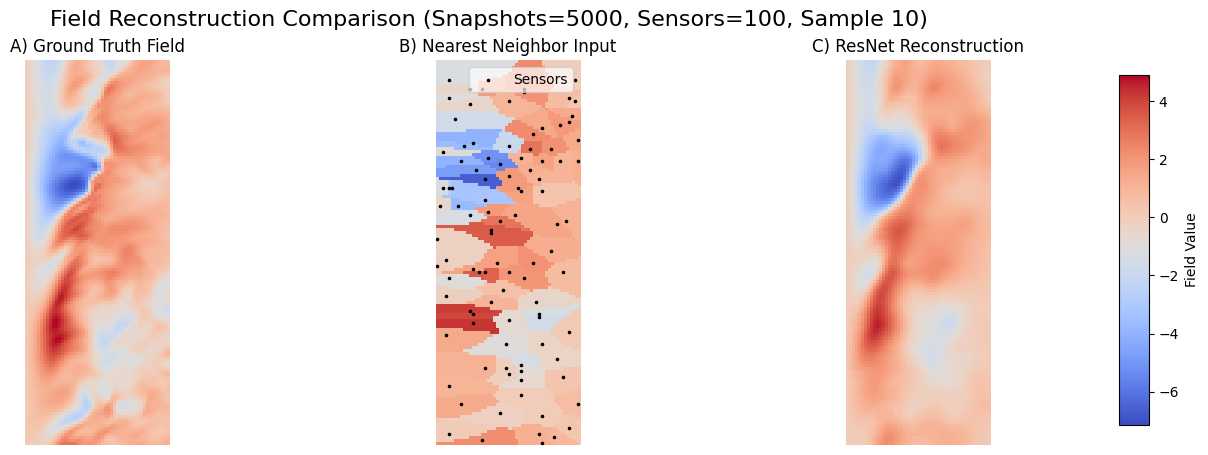


Prediction MSE (on this sample): 0.446603


In [11]:
run_reconstruction_inference(num_snapshots=5000, sen_num=100, sample_idx=10)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import griddata
import pickle
import os
import matplotlib.pyplot as plt
import sys

# --- Main Inference Function ---

def run_reconstruction_inference(num_snapshots=5000, sen_num=100, va=300, sample_idx=10):
    """
    Performs field reconstruction inference using a trained ResNet model.

    Args:
        num_snapshots (int): The total number of snapshots to load from the data.
        sen_num (int): The number of sparse sensor locations to simulate.
        va (int): Seed for the random sensor locations (variable kind).
        sample_idx (int): Index of the sample from the test set to plot.
    """
    
    dim_1 = 128 # Latitude dimension
    dim_2 = 48  # Longitude dimension
    model_save_path = './Model_ResNet_2Dxysec_weights.pth'
    
    print(f"--- Starting Inference: Snapshots={num_snapshots}, Sensors={sen_num}, Sample={sample_idx} ---")

    ## 1. Data Loading and Setup
    try:
        xcor = pd.read_csv('./record_x.csv', header=None, delim_whitespace=True).values
        ycor = pd.read_csv('./record_y.csv', header=None, delim_whitespace=True).values
        xc = xcor[0:dim_1, 0]
        yc = ycor[0:dim_2, 0]
        with open("./ch_2Dxysec.pickle", 'rb') as f:
            omg_flc_all = pickle.load(f)
    except FileNotFoundError as e:
        print(f"ERROR: Data file not found for loading: {e.filename}. Cannot proceed.")
        sys.exit(1)
    
    # Check if we have enough snapshots
    if num_snapshots > omg_flc_all.shape[0]:
        print(f"ERROR: Requested snapshots ({num_snapshots}) exceeds available data ({omg_flc_all.shape[0]}).")
        sys.exit(1)

    ## 2. Preprocessing and Sparse Sampling
    x_ref, y_ref = np.meshgrid(yc, xc)
    total_samples = num_snapshots
    X_ki = np.zeros((total_samples, dim_1, dim_2, 2))
    y_ki = np.zeros((total_samples, dim_1, dim_2, 1))

    for t in tqdm(range(num_snapshots), desc="Preprocessing Snapshots"):
        # Ground Truth
        y_ki[t, :, :, 0] = omg_flc_all[t, :, :, 0]
        
        # Sparse Locations (Input Channel 0: Nearest Neighbor Interpolation)
        np.random.seed(va) 
        sparse_locations_lat = np.random.randint(dim_1, size=sen_num)
        sparse_locations_lon = np.random.randint(dim_2, size=sen_num)

        sparse_data = np.zeros(sen_num)
        for s in range(sen_num):
            sparse_data[s] = omg_flc_all[t, :, :, 0][
                int(sparse_locations_lat[s]), int(sparse_locations_lon[s])
            ]

        sparse_locations_ex = np.zeros((sen_num, 2))
        for i in range(sen_num):
            sparse_locations_ex[i, 0] = xc[int(sparse_locations_lat[i])]
            sparse_locations_ex[i, 1] = yc[int(sparse_locations_lon[i])]

        grid_z0 = griddata(sparse_locations_ex, sparse_data, (y_ref, x_ref), method='nearest')
        X_ki[t, :, :, 0] = grid_z0

        # Mask Image (Input Channel 1: Sensor Mask)
        mask_img = np.zeros(grid_z0.shape)
        for i in range(sen_num):
            mask_img[int(sparse_locations_lat[i]), int(sparse_locations_lon[i])] = 1
        X_ki[t, :, :, 1] = mask_img

    ## 3. Train-Test Split and Tensor Conversion
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_ki, y_ki, test_size=0.3, random_state=42
    )
    
    # Convert to Tensors and permute for PyTorch (N, H, W, C) -> (N, C, H, W)
    X_test_tensor = torch.from_numpy(X_test_np).float().permute(0, 3, 1, 2).to(device)
    y_test_tensor = torch.from_numpy(y_test_np).float().permute(0, 3, 1, 2).to(device)
    
    # Check if the requested sample index is valid
    if sample_idx >= X_test_tensor.shape[0] or sample_idx < 0:
        print(f"ERROR: Invalid sample_idx ({sample_idx}). Must be between 0 and {X_test_tensor.shape[0]-1}.")
        sys.exit(1)


    ## 4. Model Loading and Inference
    model = ResNetReconstructor(dim_1, dim_2).to(device)
    
    try:
        model.load_state_dict(torch.load(model_save_path, map_location=device))
        model.eval() # Set model to evaluation mode
        print(f"Successfully loaded model weights from {model_save_path}")
    except FileNotFoundError:
        print(f"ERROR: Model weights file not found at {model_save_path}. Cannot proceed.")
        sys.exit(1)

    print(f"Generating prediction for sample index {sample_idx} from the test set...")
    
    x_sample = X_test_tensor[sample_idx:sample_idx+1]
    y_true = y_test_tensor[sample_idx]

    with torch.no_grad():
        y_pred_tensor = model(x_sample)

    ## 5. Prepare for Plotting
    x_input_np = x_sample.cpu().numpy()[0, 0, :, :] 
    x_mask_np = x_sample.cpu().numpy()[0, 1, :, :] 
    y_true_np = y_true.cpu().numpy()[0, :, :]      
    y_pred_np = y_pred_tensor.cpu().numpy()[0, 0, :, :] 

    ## 6. Plotting
    def plot_field(data, title, ax):
        """Utility function to plot a 2D field with consistent settings."""
        # Use vmin/vmax from ground truth for consistent coloring across plots
        v_min = y_true_np.min()
        v_max = y_true_np.max()
        
        im = ax.imshow(data, cmap='coolwarm', origin='lower', vmin=v_min, vmax=v_max)
        ax.set_title(title)
        ax.axis('off')
        return im

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    im1 = plot_field(y_true_np, "A) Ground Truth Field", axes[0])

    im2 = plot_field(x_input_np, "B) Nearest Neighbor Input", axes[1])
    sensor_locs = np.argwhere(x_mask_np == 1)
    if sensor_locs.size > 0:
        # Scatter plot for sensor locationss
        axes[1].scatter(sensor_locs[:, 1], sensor_locs[:, 0], c='k', marker='.', s=10, label='Sensors')
        axes[1].legend(loc='upper right', framealpha=0.7)

    im3 = plot_field(y_pred_np, "C) ResNet Reconstruction", axes[2])

    fig.subplots_adjust(right=0.9)
    # Add a single colorbar for all plots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax, label='Field Value')

    plt.suptitle(f"Field Reconstruction Comparison (Snapshots={num_snapshots}, Sensors={sen_num}, Sample {sample_idx})", fontsize=16)
    plt.show()

    ## 7. Calculate and Print Error
    error = np.mean((y_true_np - y_pred_np)**2)
    print(f"\nPrediction MSE (on this sample): {error:.6f}")
    